In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

np.random.seed(7)

Using TensorFlow backend.


In [12]:
from slim21 import LSTMs
import os.path

pth = '/home/wolveszhao/zhaozhuo/CSE885Final'
os.chdir(pth)

There are 62 days on record
There are 62 days on record


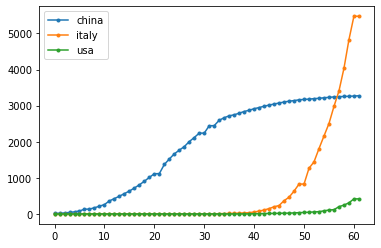

In [13]:
df = pd.read_csv(pth + '/Data/time_series_19-covid-Deaths_archived_0325.csv')
countries=df[df.columns[1]] # country names 
columns=df.columns #labels 

def get_country_total(country):
    all_pop = []
    for col in country.columns[4:]:
        all_pop.append(country[col].sum())
    return all_pop

china = df[countries=='China']
usa =df[countries=='US']
hubei=china[china[china.columns[0]]=='Hubei']
italy = df[countries=='Italy']
china = df[countries=='China']

print("There are {} days on record".format(len(china.columns)-4))
print("There are {} days on record".format(len(italy.columns)-4))

hubei_pop = np.array(np.array(hubei)[0,4:],dtype=float)
italy_pop = np.array(italy)[0,4:].astype(np.float64)
usa_pop = np.array(usa)
plt.plot(np.arange(0,62,1),get_country_total(china),'.-',label='china')
plt.plot(np.arange(0,62,1),get_country_total(italy),'.-',label='italy')
plt.plot(np.arange(0,62,1),get_country_total(usa),'.-',label='usa')
# plt.yscale('log')
# plt.xscale('log')
plt.legend()

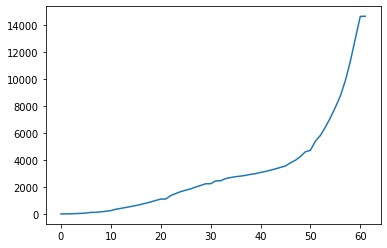

In [14]:
world = get_country_total(df)
plt.plot(range(len(world)),world)

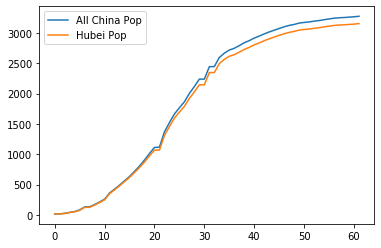

In [15]:
# np.unique(usa[columns[0]])

all_china=get_country_total(china)
plt.plot(range(len(all_china)),all_china,label='All China Pop')
plt.plot(range(len(hubei_pop)),hubei_pop,label='Hubei Pop')
plt.legend()

[  17.   17.   24.   40.   52.   76.  125.  125.  162.  204.  249.  350.
  414.  479.  549.  618.  699.  780.  871.  974. 1068. 1068. 1310. 1457.
 1596. 1696. 1789. 1921. 2029. 2144. 2144. 2346. 2346. 2495. 2563. 2615.
 2641. 2682. 2727. 2761. 2803. 2835. 2871. 2902. 2931. 2959. 2986. 3008.
 3024. 3046. 3056. 3062. 3075. 3085. 3099. 3111. 3122. 3130. 3133. 3139.
 3144. 3153.]


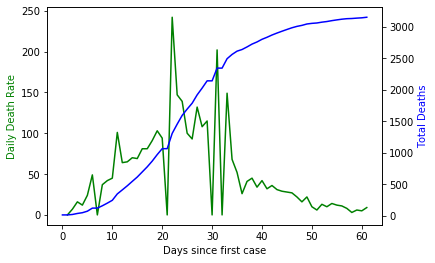

In [16]:
print(hubei_pop)
you=hubei_pop[0]
deltas=[]
for me in hubei_pop[1:]:
    deltas.append(me-you)
    you=me
    
days=np.arange(0,len(hubei_pop),1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1,len(deltas)+1,1), deltas, 'g-')
ax2.plot(days, hubei_pop, 'b-')

ax1.set_xlabel('Days since first case')
ax1.set_ylabel('Daily Death Rate', color='g')
ax2.set_ylabel('Total Deaths', color='b')

plt.show()

Directory  tanh-eta1.2e-05  already exists
[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
49 13
X_train
 (47, 1)
y_train
 (47, 1)
y_train
[[0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]
 [0.01881378]]
Epoch 1/50
 - 7s - loss: 0.3515
Epoch 2/50
 - 0s - loss: 0.2556
Epoch 3/50
 - 0s - loss: 0.1866
Epoch 4/50
 - 0s - loss: 0.1431
Epoch 5/50
 - 0s - loss: 0.1149
Epoch 6/50
 - 0s - loss: 0.0977
Epoch 7/50
 - 0s - loss: 0.0863
Epoch 8/50
 - 0s - loss: 0.0792
Epoch 9/50
 - 0s - loss: 0.0742
Epoch 10/50
 - 0s - loss: 0.0698
Epoch 11/50
 - 0s - loss: 0.0656
Epoch 12/50
 - 0s - loss: 0.0619
Epoch 13/50
 - 0s - loss: 0.0580
Epoch 14/50
 - 0s - loss: 0.0539
Epoch 15/50
 - 0s - loss: 0.0501
Epoch 16/50
 - 0s - loss: 0.0466
Epoch 17/50
 - 0s - loss: 0.0425
Epoch 18/50
 - 0s - loss: 0.0381
Epoch 19/50
 - 0s - loss: 0.0344
Epoch 20/50
 - 0s - loss: 0.0311
Epoch 21/50
 - 0s - loss: 0.0269
Epoch 22/50


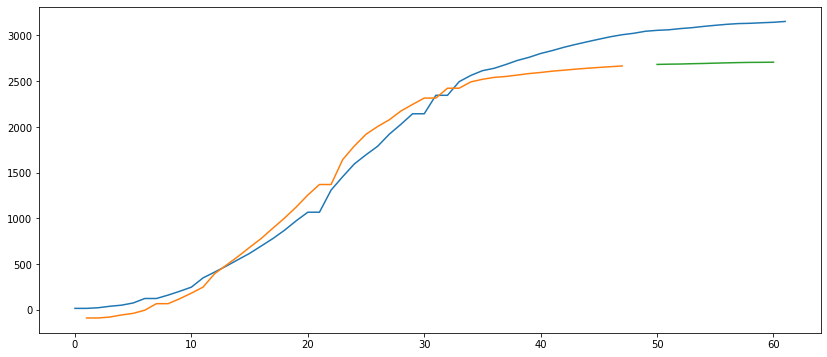

[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
49 13
X_train
 (47, 1)
y_train
 (47, 1)
y_train
[[0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]
 [0.01881378]]
Epoch 1/50
 - 7s - loss: 0.3532
Epoch 2/50
 - 0s - loss: 0.2600
Epoch 3/50
 - 0s - loss: 0.1935
Epoch 4/50
 - 0s - loss: 0.1516
Epoch 5/50
 - 0s - loss: 0.1242
Epoch 6/50
 - 0s - loss: 0.1067
Epoch 7/50
 - 0s - loss: 0.0949
Epoch 8/50
 - 0s - loss: 0.0873
Epoch 9/50
 - 0s - loss: 0.0821
Epoch 10/50
 - 0s - loss: 0.0777
Epoch 11/50
 - 0s - loss: 0.0738
Epoch 12/50
 - 0s - loss: 0.0706
Epoch 13/50
 - 0s - loss: 0.0673
Epoch 14/50
 - 0s - loss: 0.0639
Epoch 15/50
 - 0s - loss: 0.0608
Epoch 16/50
 - 0s - loss: 0.0579
Epoch 17/50
 - 0s - loss: 0.0545
Epoch 18/50
 - 0s - loss: 0.0507
Epoch 19/50
 - 0s - loss: 0.0476
Epoch 20/50
 - 0s - loss: 0.0449
Epoch 21/50
 - 0s - loss: 0.0410
Epoch 22/50
 - 0s - loss: 0.0380
Epoch 23/50
 - 0s - lo

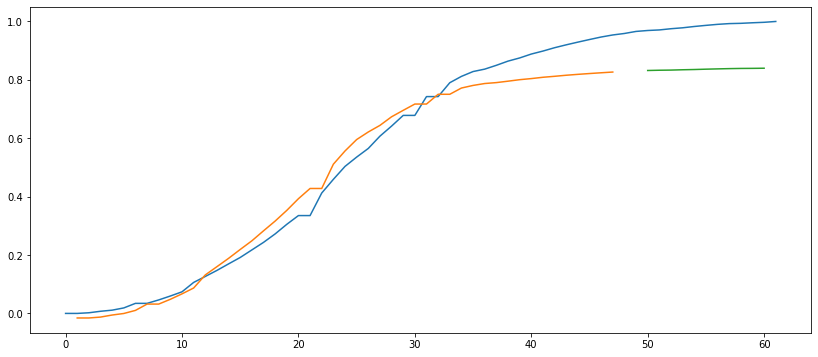

[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
49 13
X_train
 (47, 1)
y_train
 (47, 1)
y_train
[[0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]
 [0.01881378]]
Epoch 1/50
 - 7s - loss: 0.3257
Epoch 2/50
 - 0s - loss: 0.2264
Epoch 3/50
 - 0s - loss: 0.1584
Epoch 4/50
 - 0s - loss: 0.1190
Epoch 5/50
 - 0s - loss: 0.0956
Epoch 6/50
 - 0s - loss: 0.0818
Epoch 7/50
 - 0s - loss: 0.0738
Epoch 8/50
 - 0s - loss: 0.0683
Epoch 9/50
 - 0s - loss: 0.0633
Epoch 10/50
 - 0s - loss: 0.0599
Epoch 11/50
 - 0s - loss: 0.0551
Epoch 12/50
 - 0s - loss: 0.0511
Epoch 13/50
 - 0s - loss: 0.0474
Epoch 14/50
 - 0s - loss: 0.0434
Epoch 15/50
 - 0s - loss: 0.0395
Epoch 16/50
 - 0s - loss: 0.0359
Epoch 17/50
 - 0s - loss: 0.0320
Epoch 18/50
 - 0s - loss: 0.0286
Epoch 19/50
 - 0s - loss: 0.0254
Epoch 20/50
 - 0s - loss: 0.0222
Epoch 21/50
 - 0s - loss: 0.0193
Epoch 22/50
 - 0s - loss: 0.0166
Epoch 23/50
 - 0s - lo

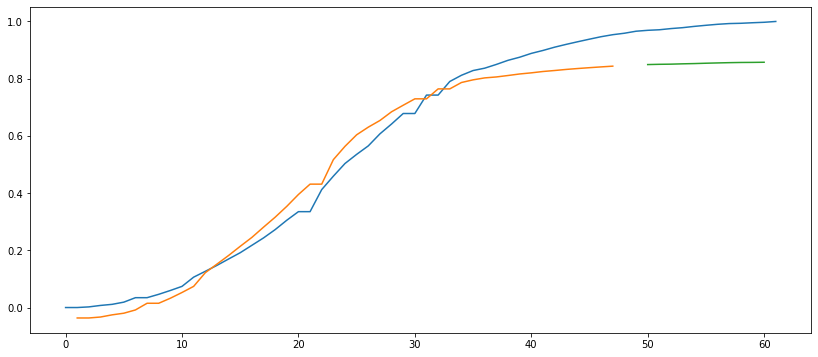

[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
49 13
X_train
 (47, 1)
y_train
 (47, 1)
y_train
[[0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]
 [0.01881378]]
Epoch 1/50
 - 8s - loss: 0.3069
Epoch 2/50
 - 0s - loss: 0.2271
Epoch 3/50
 - 0s - loss: 0.1698
Epoch 4/50
 - 0s - loss: 0.1297
Epoch 5/50
 - 0s - loss: 0.1061
Epoch 6/50
 - 0s - loss: 0.0901
Epoch 7/50
 - 0s - loss: 0.0811
Epoch 8/50
 - 0s - loss: 0.0757
Epoch 9/50
 - 0s - loss: 0.0704
Epoch 10/50
 - 0s - loss: 0.0670
Epoch 11/50
 - 0s - loss: 0.0632
Epoch 12/50
 - 0s - loss: 0.0599
Epoch 13/50
 - 0s - loss: 0.0564
Epoch 14/50
 - 0s - loss: 0.0533
Epoch 15/50
 - 0s - loss: 0.0501
Epoch 16/50
 - 0s - loss: 0.0469
Epoch 17/50
 - 0s - loss: 0.0438
Epoch 18/50
 - 0s - loss: 0.0407
Epoch 19/50
 - 0s - loss: 0.0376
Epoch 20/50
 - 0s - loss: 0.0345
Epoch 21/50
 - 0s - loss: 0.0318
Epoch 22/50
 - 0s - loss: 0.0288
Epoch 23/50
 - 0s - lo

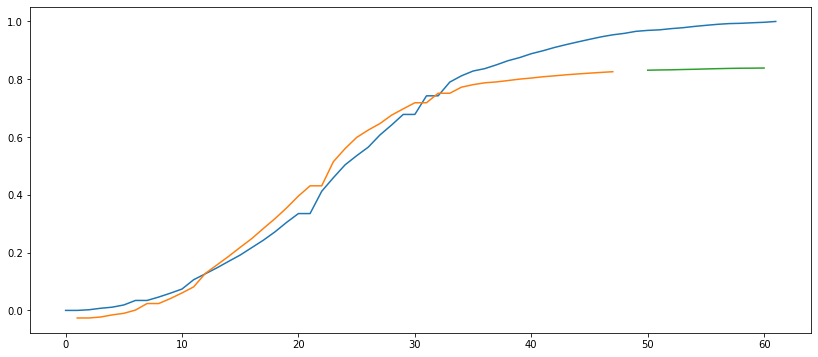

[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
49 13
X_train
 (47, 1)
y_train
 (47, 1)
y_train
[[0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]
 [0.01881378]]
Epoch 1/50
 - 8s - loss: 0.3063
Epoch 2/50
 - 0s - loss: 0.2220
Epoch 3/50
 - 0s - loss: 0.1610
Epoch 4/50
 - 0s - loss: 0.1186
Epoch 5/50
 - 0s - loss: 0.0950
Epoch 6/50
 - 0s - loss: 0.0797
Epoch 7/50
 - 0s - loss: 0.0716
Epoch 8/50
 - 0s - loss: 0.0668
Epoch 9/50
 - 0s - loss: 0.0616
Epoch 10/50
 - 0s - loss: 0.0579
Epoch 11/50
 - 0s - loss: 0.0537
Epoch 12/50
 - 0s - loss: 0.0497
Epoch 13/50
 - 0s - loss: 0.0456
Epoch 14/50
 - 0s - loss: 0.0418
Epoch 15/50
 - 0s - loss: 0.0378
Epoch 16/50
 - 0s - loss: 0.0340
Epoch 17/50
 - 0s - loss: 0.0304
Epoch 18/50
 - 0s - loss: 0.0268
Epoch 19/50
 - 0s - loss: 0.0234
Epoch 20/50
 - 0s - loss: 0.0202
Epoch 21/50
 - 0s - loss: 0.0175
Epoch 22/50
 - 0s - loss: 0.0147
Epoch 23/50
 - 0s - lo

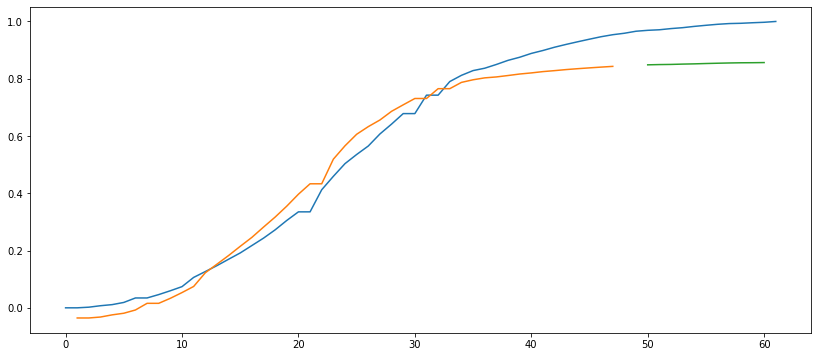

[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
49 13
X_train
 (47, 1)
y_train
 (47, 1)
y_train
[[0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]
 [0.01881378]]
Epoch 1/50
 - 7s - loss: 0.3280
Epoch 2/50
 - 0s - loss: 0.1389
Epoch 3/50
 - 0s - loss: 0.0859
Epoch 4/50
 - 0s - loss: 0.0717
Epoch 5/50
 - 0s - loss: 0.0608
Epoch 6/50
 - 0s - loss: 0.0516
Epoch 7/50
 - 0s - loss: 0.0435
Epoch 8/50
 - 0s - loss: 0.0361
Epoch 9/50
 - 0s - loss: 0.0294
Epoch 10/50
 - 0s - loss: 0.0246
Epoch 11/50
 - 0s - loss: 0.0191
Epoch 12/50
 - 0s - loss: 0.0153
Epoch 13/50
 - 0s - loss: 0.0123
Epoch 14/50
 - 0s - loss: 0.0098
Epoch 15/50
 - 0s - loss: 0.0079
Epoch 16/50
 - 0s - loss: 0.0065
Epoch 17/50
 - 0s - loss: 0.0054
Epoch 18/50
 - 0s - loss: 0.0046
Epoch 19/50
 - 0s - loss: 0.0040
Epoch 20/50
 - 0s - loss: 0.0036
Epoch 21/50
 - 0s - loss: 0.0032
Epoch 22/50
 - 0s - loss: 0.0030
Epoch 23/50
 - 0s - lo

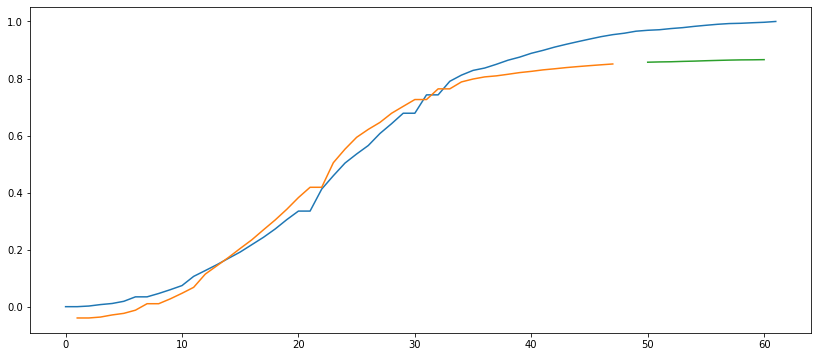

[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
49 13
X_train
 (47, 1)
y_train
 (47, 1)
y_train
[[0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]
 [0.01881378]]
Epoch 1/50
 - 7s - loss: 0.1309
Epoch 2/50
 - 0s - loss: 0.0731
Epoch 3/50
 - 0s - loss: 0.0518
Epoch 4/50
 - 0s - loss: 0.0430
Epoch 5/50
 - 0s - loss: 0.0376
Epoch 6/50
 - 0s - loss: 0.0333
Epoch 7/50
 - 0s - loss: 0.0294
Epoch 8/50
 - 0s - loss: 0.0256
Epoch 9/50
 - 0s - loss: 0.0224
Epoch 10/50
 - 0s - loss: 0.0189
Epoch 11/50
 - 0s - loss: 0.0165
Epoch 12/50
 - 0s - loss: 0.0137
Epoch 13/50
 - 0s - loss: 0.0115
Epoch 14/50
 - 0s - loss: 0.0096
Epoch 15/50
 - 0s - loss: 0.0081
Epoch 16/50
 - 0s - loss: 0.0069
Epoch 17/50
 - 0s - loss: 0.0059
Epoch 18/50
 - 0s - loss: 0.0051
Epoch 19/50
 - 0s - loss: 0.0046
Epoch 20/50
 - 0s - loss: 0.0041
Epoch 21/50
 - 0s - loss: 0.0037
Epoch 22/50
 - 0s - loss: 0.0035
Epoch 23/50
 - 0s - lo

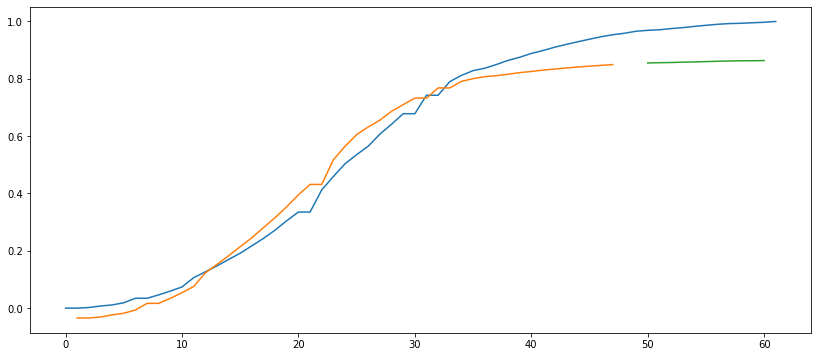

[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
49 13
X_train
 (47, 1)
y_train
 (47, 1)
y_train
[[0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]
 [0.01881378]]
Epoch 1/50
 - 8s - loss: 0.1300
Epoch 2/50
 - 0s - loss: 0.0708
Epoch 3/50
 - 0s - loss: 0.0495
Epoch 4/50
 - 0s - loss: 0.0409
Epoch 5/50
 - 0s - loss: 0.0355
Epoch 6/50
 - 0s - loss: 0.0311
Epoch 7/50
 - 0s - loss: 0.0270
Epoch 8/50
 - 0s - loss: 0.0232
Epoch 9/50
 - 0s - loss: 0.0199
Epoch 10/50
 - 0s - loss: 0.0164
Epoch 11/50
 - 0s - loss: 0.0140
Epoch 12/50
 - 0s - loss: 0.0113
Epoch 13/50
 - 0s - loss: 0.0092
Epoch 14/50
 - 0s - loss: 0.0076
Epoch 15/50
 - 0s - loss: 0.0063
Epoch 16/50
 - 0s - loss: 0.0053
Epoch 17/50
 - 0s - loss: 0.0046
Epoch 18/50
 - 0s - loss: 0.0040
Epoch 19/50
 - 0s - loss: 0.0037
Epoch 20/50
 - 0s - loss: 0.0034
Epoch 21/50
 - 0s - loss: 0.0032
Epoch 22/50
 - 0s - loss: 0.0031
Epoch 23/50
 - 0s - lo

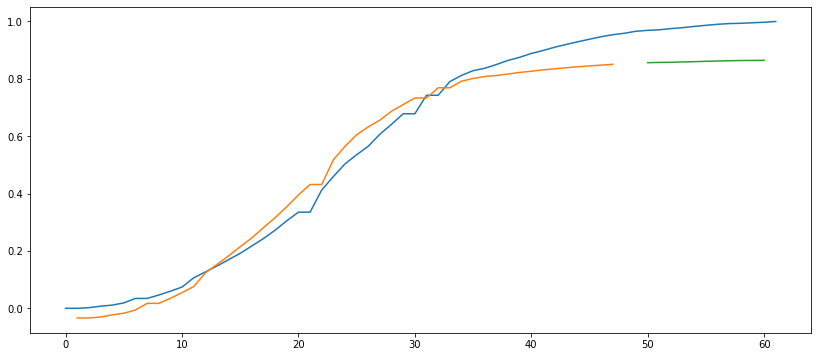

[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
49 13
X_train
 (47, 1)
y_train
 (47, 1)
y_train
[[0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]
 [0.01881378]]
Epoch 1/50
 - 8s - loss: 0.3702
Epoch 2/50
 - 0s - loss: 0.2912
Epoch 3/50
 - 0s - loss: 0.2318
Epoch 4/50
 - 0s - loss: 0.1866
Epoch 5/50
 - 0s - loss: 0.1534
Epoch 6/50
 - 0s - loss: 0.1300
Epoch 7/50
 - 0s - loss: 0.1141
Epoch 8/50
 - 0s - loss: 0.1020
Epoch 9/50
 - 0s - loss: 0.0939
Epoch 10/50
 - 0s - loss: 0.0877
Epoch 11/50
 - 0s - loss: 0.0826
Epoch 12/50
 - 0s - loss: 0.0783
Epoch 13/50
 - 0s - loss: 0.0742
Epoch 14/50
 - 0s - loss: 0.0704
Epoch 15/50
 - 0s - loss: 0.0666
Epoch 16/50
 - 0s - loss: 0.0625
Epoch 17/50
 - 0s - loss: 0.0585
Epoch 18/50
 - 0s - loss: 0.0542
Epoch 19/50
 - 0s - loss: 0.0501
Epoch 20/50
 - 0s - loss: 0.0460
Epoch 21/50
 - 0s - loss: 0.0419
Epoch 22/50
 - 0s - loss: 0.0383
Epoch 23/50
 - 0s - lo

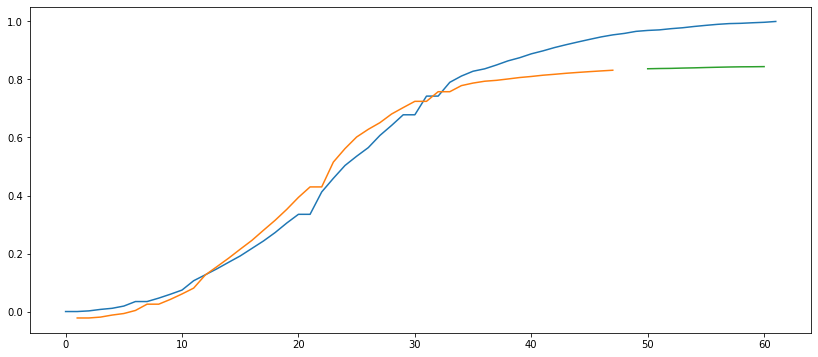

[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
[[0.        ]
 [0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]]
49 13
X_train
 (47, 1)
y_train
 (47, 1)
y_train
[[0.        ]
 [0.00223214]
 [0.00733418]
 [0.01116071]
 [0.01881378]]
Epoch 1/50
 - 9s - loss: 0.3701
Epoch 2/50
 - 0s - loss: 0.2903
Epoch 3/50
 - 0s - loss: 0.2292
Epoch 4/50
 - 0s - loss: 0.1814
Epoch 5/50
 - 0s - loss: 0.1458
Epoch 6/50
 - 0s - loss: 0.1212
Epoch 7/50
 - 0s - loss: 0.1054
Epoch 8/50
 - 0s - loss: 0.0937
Epoch 9/50
 - 0s - loss: 0.0865
Epoch 10/50
 - 0s - loss: 0.0807
Epoch 11/50
 - 0s - loss: 0.0756
Epoch 12/50
 - 0s - loss: 0.0710
Epoch 13/50
 - 0s - loss: 0.0663
Epoch 14/50
 - 0s - loss: 0.0616
Epoch 15/50
 - 0s - loss: 0.0566
Epoch 16/50
 - 0s - loss: 0.0510
Epoch 17/50
 - 0s - loss: 0.0454
Epoch 18/50
 - 0s - loss: 0.0393
Epoch 19/50
 - 0s - loss: 0.0335
Epoch 20/50
 - 0s - loss: 0.0278
Epoch 21/50
 - 0s - loss: 0.0224
Epoch 22/50
 - 0s - loss: 0.0180
Epoch 23/50
 - 0s - lo

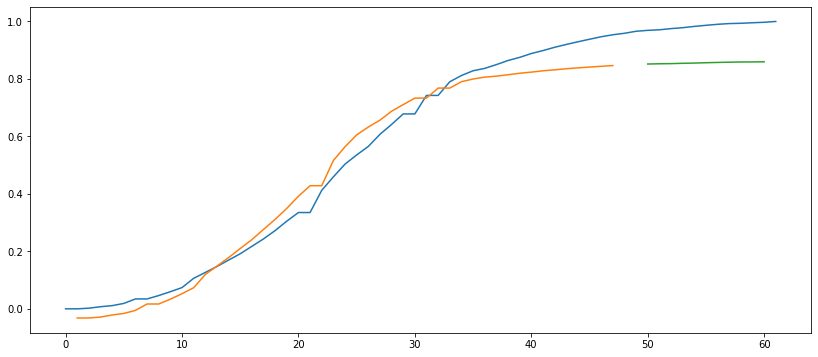

In [38]:
Data = hubei_pop.reshape((len(hubei_pop),1))

def create_dataset(data, look_back=1):
    f = len(data)-look_back
    return data[:f-1],data[1:f]


#Slim LSTM training

acts = ['tanh'] #'sigmoid' ,'tanh'
#include all your models ina list
lstms = ['LSTM1', 'LSTM2', 'LSTM3', 'LSTM4', 'LSTM5', 'LSTM6', 'LSTM4a', 'LSTM5a', 'LSTM10', 'LSTM11']
#inlcude all your lr (grid) in a list
etas = [1.2e-5]
#Use the name label of the model for the file
names = ['lstm1', 'lstm2', 'lstm3', 'lstm4', 'lstm5', 'lstm6', 'lstm4a', 'lstm5a', 'lstm10', 'lstm11']

for act in acts:
    for eta in etas:
        sub = '%s-eta%.4g' % (act,eta)
        if not os.path.exists(sub):
            os.mkdir(sub)
            print("Directory " , sub ,  " Created ")
        else:    
            print("Directory " , sub ,  " already exists")  
        for cnt, lstm in enumerate(lstms):
            scaler = MinMaxScaler(feature_range=(0, 1))
            print(dataset[:5])
            dataset = scaler.fit_transform(Data) # normalize data
            print(dataset[:5])

            train_size = int(len(dataset) * 0.80)
            test_size = len(dataset) - train_size
            train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
            print(len(train), len(test))
            # print(f'train\n{train}')
            # print(f'test\n{test.shape}')

            look_back = 1
            X_train, y_train = create_dataset(train, look_back)
            print(f'X_train\n {X_train.shape}')
            print(f'y_train\n {y_train.shape}')
            X_test, y_test = create_dataset(test, look_back)

            X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
            X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
            print(f'y_train\n{y_train[:5]}')
            
            np.random.seed(3)
            model = Sequential()           
            lstmi = LSTMs(implementation= 1, units=10,
                    activation=act,
                    input_shape=X_train.shape[1:], model=lstm)
            model.add(lstmi)
            model.add(Dense(1, activation=act))
            model.compile(loss='mean_squared_error', optimizer='adam')
            model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2) 
            
            # make predictions
            trainPredict = model.predict(X_train)
            print(f'trainPredic\n{trainPredict}')
            testPredict = model.predict(X_test)
            #print(f'testPredic\n{testPredict}')
            # invert predictions  ??
            trainPredict = scaler.inverse_transform(trainPredict)
            #print(f'trainPredict\n{trainPredict[:5]}')
            y_train = scaler.inverse_transform(y_train)
            print(f'y_train\n{y_train[:5]}')
            testPredict = scaler.inverse_transform(testPredict)
            print(f'trainPredict\n{trainPredict[:5]}')
            y_test = scaler.inverse_transform(y_test)
            # calculate root mean squared error
            trainScore = math.sqrt(mean_squared_error(y_train[:,0], trainPredict[:,0]))
            print('Train Score: %.2f RMSE' % (trainScore))
            testScore = math.sqrt(mean_squared_error(y_test[:,0], testPredict[:,0]))
            print('Test Score: %.2f RMSE' % (testScore))


            plt.figure(figsize=(14,6))
            # shift train predictions for plotting
            trainPredictPlot = np.empty_like(dataset)
            trainPredictPlot[:, :] = np.nan
            trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
            # shift test predictions for plotting
            testPredictPlot = np.empty_like(dataset)
            testPredictPlot[:, :] = np.nan
            testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
            # plot baseline and predictions
            Data = dataset
            plt.plot(scaler.inverse_transform(Data))
            plt.plot(trainPredictPlot)
            plt.plot(testPredictPlot)
            plt.show()

# create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)